#FINANCE - BAPTISTE

Attention, certaines des requêtes ci-dessous n'ont pas été utilisées, car jugées non pertinentes ou simplement elles renvoyaient un résultat incorrect.

## KPI CA PAR COUNTRY LAST 2 months

In [ ]:
SELECT  sum(od.`quantityOrdered` * od.`priceEach`) as Total_CA, offi.country
FROM customers c
join orders o on o.`customerNumber`=c.`customerNumber`
join orderdetails od on od.`orderNumber`=o.`orderNumber`
join employees e on e.`employeeNumber`=c.`salesRepEmployeeNumber`
join offices as offi on offi.`officeCode`=e.`officeCode`
WHERE o.orderDate >=  DATE_SUB(CURRENT_DATE(), INTERVAL 2 MONTH)
group by offi.country
order by Total_CA DESC

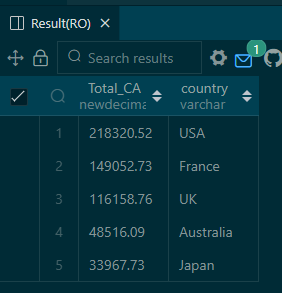

##Last two month vs last two months previous year

In [ ]:
SELECT
    SUM(od.quantityOrdered * od.priceEach) as Total_CA,
    offi.country as pays,
    total_ca_pyear.total_ca_pyear AS Total_CA_Prec,
    CONCAT(ROUND((SUM(od.quantityOrdered * od.priceEach) - total_ca_pyear.total_ca_pyear)/total_ca_pyear.total_ca_pyear*100,1),"%") as progression,
    offi.territory as continent,
    c.customerName as client
FROM
    customers c
JOIN
    orders o ON o.customerNumber = c.customerNumber
JOIN
    orderdetails od ON od.orderNumber = o.orderNumber
JOIN
    employees e ON e.employeeNumber = c.salesRepEmployeeNumber
JOIN
    offices AS offi ON offi.officeCode = e.officeCode
LEFT JOIN
    (SELECT
         SUM(od.quantityOrdered * od.priceEach) AS total_ca_pyear,
         offices.country
     FROM
         customers c
     JOIN
         orders o ON o.customerNumber = c.customerNumber
     JOIN
         orderdetails od ON od.orderNumber = o.orderNumber
     JOIN
         employees e ON e.employeeNumber = c.salesRepEmployeeNumber
     JOIN
         offices ON offices.officeCode = e.officeCode
     WHERE
         o.orderDate BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 14 MONTH) AND DATE_SUB(CURRENT_DATE(), INTERVAL 12 MONTH)
     GROUP BY
         offices.country) AS total_ca_pyear ON offi.country = total_ca_pyear.country
WHERE
    o.orderDate >= DATE_SUB(CURRENT_DATE(), INTERVAL 2 MONTH)
GROUP BY
    offi.country, offi.territory, client
ORDER BY
    Total_CA DESC;

## origine des clients par country, region

In [ ]:
SELECT  c.country as pays_clients, offi.territory as region_vente, count(c.customerNumber) as nb_clients
FROM customers c
join employees e on e.`employeeNumber`=c.`salesRepEmployeeNumber`
join offices as offi on offi.`officeCode`=e.`officeCode`
group by c.country, offi.territory
order by nb_clients DESC, region_vente

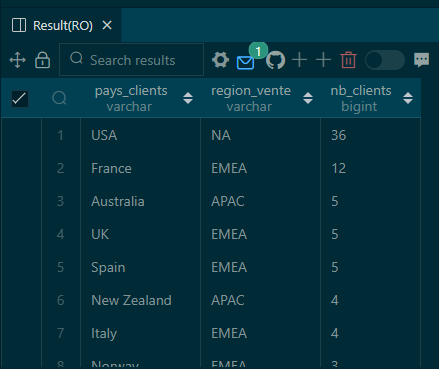

## origine des clients par pays par agence

In [ ]:
SELECT  c.country as pays_clients, offi.city as agence, count(c.customerNumber) as nb_clients
FROM customers c
join employees e on e.`employeeNumber`=c.`salesRepEmployeeNumber`
join offices as offi on offi.`officeCode`=e.`officeCode`
group by c.country, agence
order by nb_clients DESC, agence

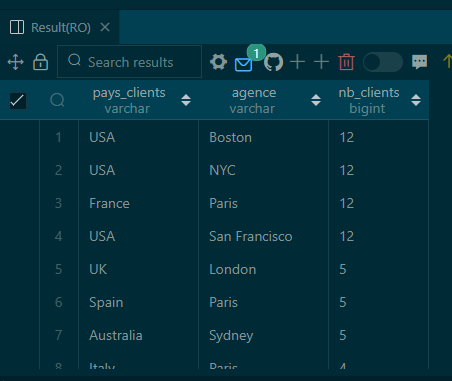

## CA par région, par année

In [ ]:
SELECT SUM(`quantityOrdered`*`priceEach`) as Total_CA, o.territory as region, YEAR(orders.orderDate) as annee
FROM orders
JOIN orderdetails on orderdetails.`orderNumber`=orders.`orderNumber`
JOIN customers on customers.`customerNumber`=orders.`customerNumber`
join employees e ON e.employeeNumber=customers.salesRepEmployeeNumber
join offices o on o.officeCode=e.officeCode
where orders.status <> "Cancelled"
GROUP BY YEAR(orders.orderDate), region
order by annee DESC, Total_CA DESC

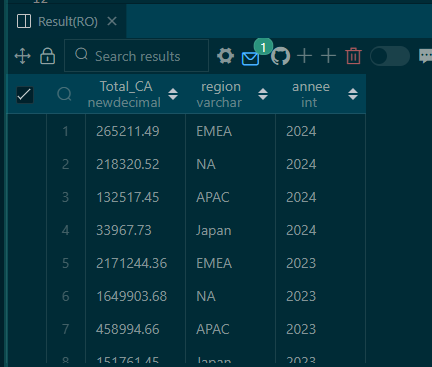

## CA par agence, par année

In [ ]:
SELECT SUM(`quantityOrdered`*`priceEach`) as Total_CA, o.city as agence, YEAR(orders.orderDate) as annee
FROM orders
JOIN orderdetails on orderdetails.`orderNumber`=orders.`orderNumber`
JOIN customers on customers.`customerNumber`=orders.`customerNumber`
JOIN employees e ON e.employeeNumber=customers.salesRepEmployeeNumber
JOIN offices o on o.officeCode=e.officeCode
GROUP BY YEAR(orders.orderDate), agence
order by annee DESC, Total_CA DESC

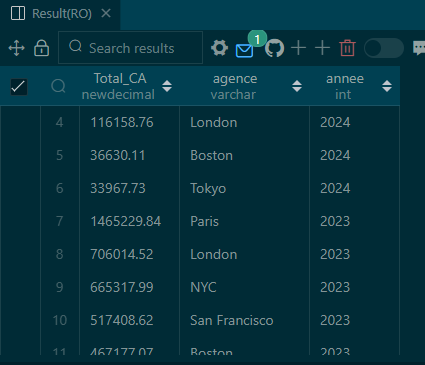

## Flop 15 clients qui sont en dépassement de limite de crédit sur les 3 derniers mois

In [ ]:
select p.paymentDate, p.amount as total_paiements, c.customerName, sum(o2.priceEach*o2.quantityOrdered) as amount_ordered,
(sum(o2.priceEach*o2.quantityOrdered)-p.amount) as credit_client, c.creditLimit,
CASE WHEN (sum(o2.priceEach*o2.quantityOrdered)-p.amount) > creditLimit THEN "Limite dépassée"
	 WHEN (sum(o2.priceEach*o2.quantityOrdered)-p.amount) <=  creditLimit THEN "Ok"
END as depassement, (sum(o2.priceEach*o2.quantityOrdered)-p.amount-creditLimit) as montant_depassement
from customers c
join payments p on p.customerNumber = c.customerNumber
join orders o on o.customerNumber = c.customerNumber
join orderdetails o2 on o2.orderNumber = o.orderNumber
where p.paymentDate >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
group by p.paymentDate, p.amount, c.customerName, c.creditLimit
order by (sum(o2.priceEach*o2.quantityOrdered)-p.amount-creditLimit) DESC
LIMIT 10

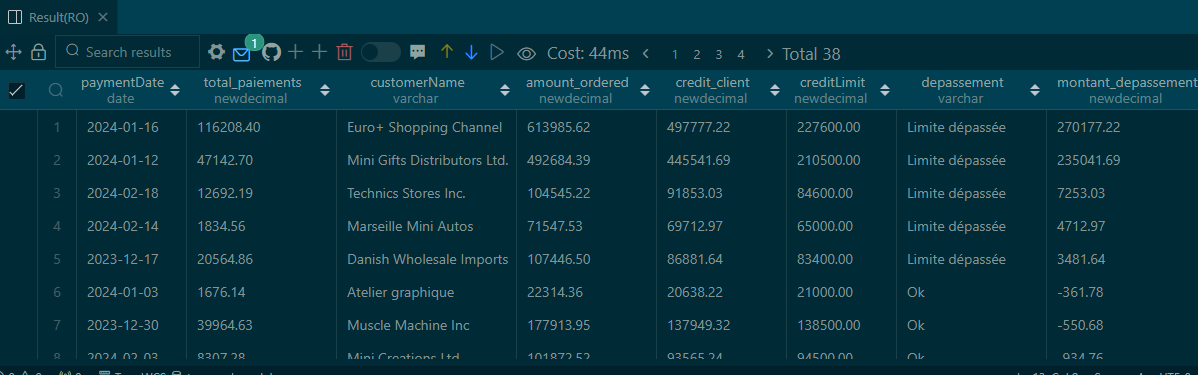

attention, ici j'ai des dépassements, mais ils sont peut être normal, négocier par le client.
ce n'est pas une information assez pertinente, elle peut induire en erreur et faire relancer un client par erreur

version corrigée, à l'aide de chat gpt :

In [ ]:
SELECT
    c.customerName,
    COALESCE(amount_ordered.total, 0) AS amount_ordered,
    COALESCE(amount_paid.total_paid, 0) AS total_paid,
    sum(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) over (PARTITION BY c.`customerName`) as encours_client,
    ROUND(SUM((COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) / COALESCE(amount_ordered.total, 0) * 100) OVER (PARTITION BY c.customerName)) AS pcent_total_encours
FROM
    customers c
JOIN
    payments p ON p.customerNumber = c.customerNumber
JOIN
    orders o ON o.customerNumber = c.customerNumber
JOIN
    orderdetails o2 ON o.orderNumber = o2.orderNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(o2.priceEach * o2.quantityOrdered) AS total
    FROM
        customers c
    JOIN
        orders o ON o.customerNumber = c.customerNumber
    JOIN
        orderdetails o2 ON o.orderNumber = o2.orderNumber
    GROUP BY
        c.customerNumber
) AS amount_ordered ON c.customerNumber = amount_ordered.customerNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(p.amount) AS total_paid
    FROM
        customers c
    JOIN
        payments p ON p.customerNumber = c.customerNumber
    GROUP BY
        c.customerNumber
) AS amount_paid ON c.customerNumber = amount_paid.customerNumber
GROUP BY
    c.customerName, amount_ordered.total, amount_paid.total_paid
ORDER BY
    encours_client DESC
LIMIT 15


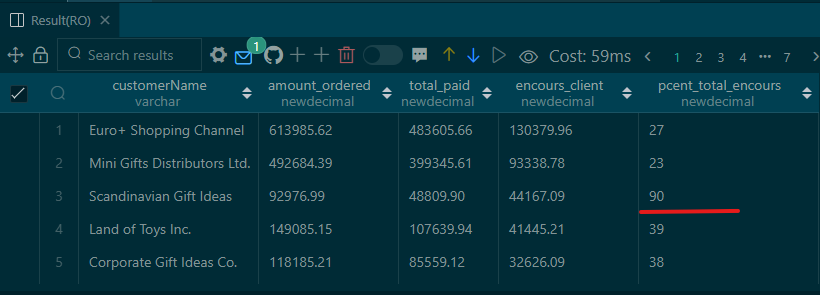

le pourcentage actuel ne me convient pas je voudrais le pourcentage de l'encours client par rapport à l'encours total de tous les clients

In [ ]:
WITH total_encours AS (
    SELECT
        SUM(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) AS total_encours
    FROM
        customers c
    JOIN
        payments p ON p.customerNumber = c.customerNumber
    JOIN
        orders o ON o.customerNumber = c.customerNumber
    JOIN
        orderdetails o2 ON o.orderNumber = o2.orderNumber
    LEFT JOIN (
        SELECT
            c.customerNumber,
            SUM(o2.priceEach * o2.quantityOrdered) AS total
        FROM
            customers c
        JOIN
            orders o ON o.customerNumber = c.customerNumber
        JOIN
            orderdetails o2 ON o.orderNumber = o2.orderNumber
        GROUP BY
            c.customerNumber
    ) AS amount_ordered ON c.customerNumber = amount_ordered.customerNumber
    LEFT JOIN (
        SELECT
            c.customerNumber,
            SUM(p.amount) AS total_paid
        FROM
            customers c
        JOIN
            payments p ON p.customerNumber = c.customerNumber
        GROUP BY
            c.customerNumber
    ) AS amount_paid ON c.customerNumber = amount_paid.customerNumber
)
SELECT
    c.customerName AS client,
    COALESCE(amount_ordered.total, 0) AS amount_ordered,
    COALESCE(amount_paid.total_paid, 0) AS total_paid,
    sum(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) OVER (PARTITION BY c.`customerName`) AS encours_client,
    ROUND(SUM((COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) / COALESCE(amount_ordered.total, 0)*100) OVER (PARTITION BY c.customerName)) AS pct_encours,
    round((sum(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) OVER (PARTITION BY c.`customerName`))*100000 / total_encours) AS pct_total_encours
FROM
    customers c
JOIN
    payments p ON p.customerNumber = c.customerNumber
JOIN
    orders o ON o.customerNumber = c.customerNumber
JOIN
    orderdetails o2 ON o.orderNumber = o2.orderNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(o2.priceEach * o2.quantityOrdered) AS total
    FROM
        customers c
    JOIN
        orders o ON o.customerNumber = c.customerNumber
    JOIN
        orderdetails o2 ON o.orderNumber = o2.orderNumber
    GROUP BY
        c.customerNumber
) AS amount_ordered ON c.customerNumber = amount_ordered.customerNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(p.amount) AS total_paid
    FROM
        customers c
    JOIN
        payments p ON p.customerNumber = c.customerNumber
    GROUP BY
        c.customerNumber
) AS amount_paid ON c.customerNumber = amount_paid.customerNumber
CROSS JOIN total_encours
GROUP BY
    c.customerName, amount_ordered.total, amount_paid.total_paid, total_encours.total_encours
ORDER BY
    pct_encours DESC, pct_total_encours DESC, encours_client DESC
LIMIT 15;

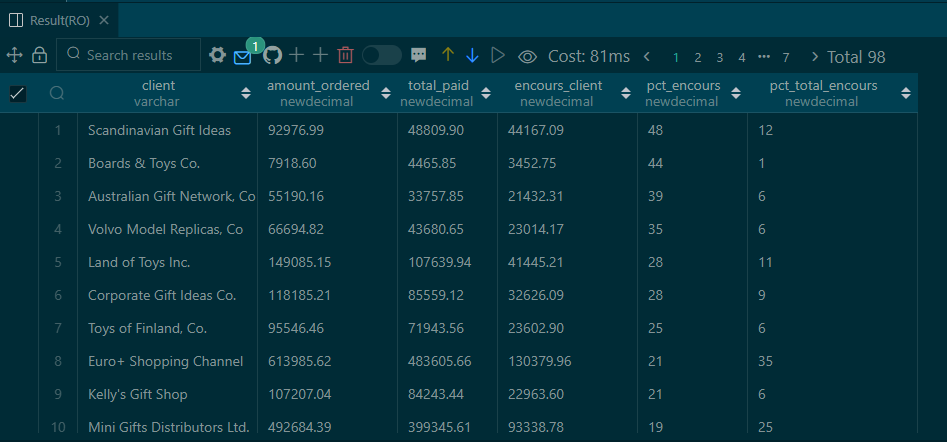

### last version

In [ ]:
WITH TotalCommands AS (
    SELECT c.customerName, SUM(o2.priceEach * o2.quantityOrdered) AS total_cmde, SUBSTR(c.customerName, 1, 18) as cust_shortname18
    FROM customers c
    LEFT JOIN orders o ON o.customerNumber = c.customerNumber AND o.status <> 'Cancelled'
    LEFT JOIN orderdetails o2 ON o2.orderNumber = o.orderNumber
    GROUP BY c.customerName),
	TotalPayments AS (
	SELECT c.customerName, SUM(p.amount) AS total_paiement, SUBSTRING(c.customerName, 1, 10) as cust_shortname
	FROM customers c
	LEFT JOIN payments p ON p.customerNumber = c.customerNumber
	GROUP BY c.customerName),
	creditlimit as(
	SELECT c.creditLimit, c.customerName, SUBSTRING(c.customerName, 0, 10) as cust_shortname
	from customers c)
SELECT COALESCE(TotalCommands.customerName, TotalPayments.customerName) AS customerName,
TotalCommands.cust_shortname18,
SUBSTRING(TotalCommands.cust_shortname18, 1, 10) as cust_shortname10,
COALESCE(TotalCommands.total_cmde, 0) AS total_cmde,
COALESCE(TotalPayments.total_paiement, 0) AS total_paiement,
COALESCE (TotalCommands.total_cmde - TotalPayments.total_paiement, 0) as encours,
creditlimit.creditLimit,
COALESCE ((TotalCommands.total_cmde - TotalPayments.total_paiement)/creditlimit.creditLimit*100, 0) as taux_utl_limite_val
CONCAT(COALESCE ((TotalCommands.total_cmde - TotalPayments.total_paiement)/creditlimit.creditLimit*100, 0),"%") as taux_utl_limite
FROM TotalCommands
LEFT JOIN TotalPayments ON TotalCommands.customerName = TotalPayments.customerName
LEFT JOIN creditlimit ON creditlimit.customerName = TotalCommands.customerName;

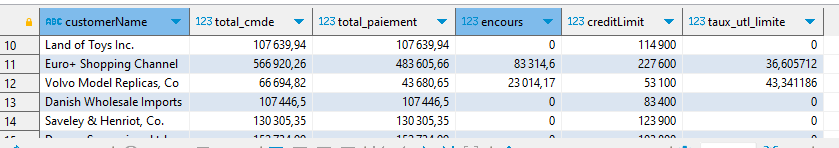

## reste à payer par client avec date dernier payment

In [ ]:
WITH total_encours AS (
    SELECT
        SUM(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) AS total_encours
    FROM
        customers c
    JOIN
        payments p ON p.customerNumber = c.customerNumber
    JOIN
        orders o ON o.customerNumber = c.customerNumber
    JOIN
        orderdetails o2 ON o.orderNumber = o2.orderNumber
    LEFT JOIN (
        SELECT
            c.customerNumber,
            SUM(o2.priceEach * o2.quantityOrdered) AS total
        FROM
            customers c
        JOIN
            orders o ON o.customerNumber = c.customerNumber
        JOIN
            orderdetails o2 ON o.orderNumber = o2.orderNumber
        GROUP BY
            c.customerNumber
    ) AS amount_ordered ON c.customerNumber = amount_ordered.customerNumber
    LEFT JOIN (
        SELECT
            c.customerNumber,
            SUM(p.amount) AS total_paid
        FROM
            customers c
        JOIN
            payments p ON p.customerNumber = c.customerNumber
        GROUP BY
            c.customerNumber
    ) AS amount_paid ON c.customerNumber = amount_paid.customerNumber
)
SELECT
    c.customerName AS client,
    sum(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) OVER (PARTITION BY c.`customerName`) AS encours_client,
    LAG(p.paymentDate) over (order by p.paymentdate DESC) as dernier_paiment
FROM
    customers c
JOIN
    payments p ON p.customerNumber = c.customerNumber
JOIN
    orders o ON o.customerNumber = c.customerNumber
JOIN
    orderdetails o2 ON o.orderNumber = o2.orderNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(o2.priceEach * o2.quantityOrdered) AS total
    FROM
        customers c
    JOIN
        orders o ON o.customerNumber = c.customerNumber
    JOIN
        orderdetails o2 ON o.orderNumber = o2.orderNumber
    GROUP BY
        c.customerNumber
) AS amount_ordered ON c.customerNumber = amount_ordered.customerNumber
LEFT JOIN (
    SELECT
        c.customerNumber,
        SUM(p.amount) AS total_paid
    FROM
        customers c
    JOIN
        payments p ON p.customerNumber = c.customerNumber
    GROUP BY
        c.customerNumber
) AS amount_paid ON c.customerNumber = amount_paid.customerNumber
CROSS JOIN total_encours
GROUP BY
    c.customerName, amount_ordered.total, amount_paid.total_paid, total_encours.total_encours, p.paymentDate
having sum(COALESCE(amount_ordered.total, 0) - COALESCE(amount_paid.total_paid, 0)) > 0
LIMIT 15;

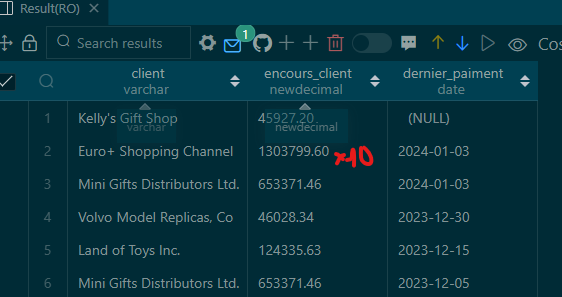

c'est très complexe pour pas grand chose et en plus cela ne marche pas, j'ai fait un KPI intermédiaire

## CA par catégorie sur les 3 derniers mois (glissant)

In [ ]:
SELECT p.`productLine`, sum(od.`quantityOrdered`*od.`priceEach`) as CA,
CASE WHEN MONTH(o.`orderDate`)=1 THEN "Janvier"
     when MONTH(o.`orderDate`)=2 THEN "Février"
     WHEN MONTH(o.`orderDate`)=3 THEN "Mars"
     when MONTH(o.`orderDate`)=4 THEN "Avril"
     WHEN MONTH(o.`orderDate`)=5 THEN "Mai"
     when MONTH(o.`orderDate`)=6 THEN "Juin"
     WHEN MONTH(o.`orderDate`)=7 THEN "Juillet"
     when MONTH(o.`orderDate`)=8 THEN "Août"
     WHEN MONTH(o.`orderDate`)=9 THEN "Septembre"
     when MONTH(o.`orderDate`)=10 THEN "Octobre"
     WHEN MONTH(o.`orderDate`)=11 THEN "Novembre"
     when MONTH(o.`orderDate`)=12 THEN "Décembre"
     else "Erreur"

END as mois, YEAR(o.`orderDate`) as annee
from orderdetails as od
join products p on p.`productCode`=od.`productCode`
join orders o on o.`orderNumber`=od.`orderNumber`
where o.orderDate >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
group by p.`productLine`, o.`orderDate`
order by YEAR(o.`orderDate`) DESC, MONTH(o.`orderDate`) DESC

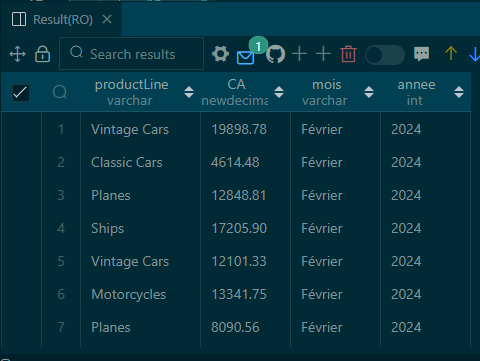

## CA par catégorie de produit sur 3 mois glissants et % par cat du CA total mm période

plus clair sur un mois IMO

In [ ]:
SELECT MONTHNAME(o.orderDate) as Mois, p.productLine as Categ, SUM((od.priceEach)*od.quantityOrdered) as CA_periode,
CONCAT(ROUND(SUM((od.priceEach) * od.quantityOrdered) / (SELECT SUM((od.priceEach)*od.quantityOrdered)
FROM orders o JOIN orderdetails od on o.orderNumber = od.orderNumber JOIN products p on p.productCode = od.productCode
WHERE (o.orderDate >= DATE_SUB(CURDATE(),INTERVAL 3 MONTH)))*100,0),'%') as Pct_CA_periode
FROM orderdetails od
JOIN orders o on o.orderNumber = od.orderNumber
JOIN products p on p.productCode = od.productCode
WHERE  o.orderDate >= DATE_SUB(CURDATE(),INTERVAL 3 MONTH)
GROUP BY  MONTHNAME(o.orderDate), p.productLine, YEAR(o.`orderDate`)
ORDER BY YEAR(o.`orderDate`) DESC, FIELD(Mois,'January','February','Mars','Avril','Mai','Juin','Juillet','Août','Septembre','Octobre','Novembre','December');

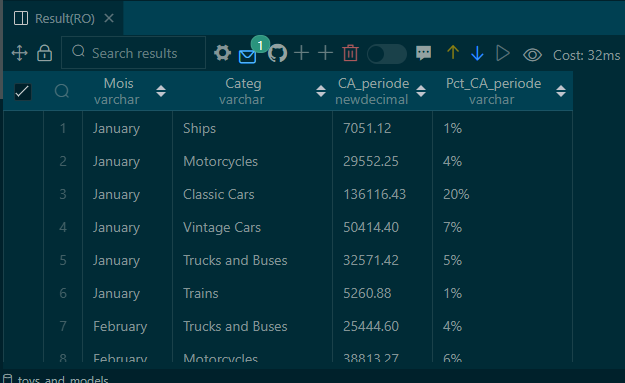

## nombre de commande par région et par année

In [ ]:
SELECT count(o.orderNumber) as nb_commande, o2.territory as region, YEAR(o.orderDate)
FROM customers c
JOIN orders o on o.customerNumber = c.customerNumber
JOIN employees e on e.employeeNumber =c.salesRepEmployeeNumber
JOIN offices o2 on o2.officeCode = e.officeCode
GROUP BY region, YEAR(o.orderDate)

## CA par client global

In [ ]:
WITH TotalCommands AS (
    SELECT c.customerName, SUM(o2.priceEach * o2.quantityOrdered) AS total_cmde
    FROM customers c
    LEFT JOIN orders o ON o.customerNumber = c.customerNumber AND o.status <> 'Cancelled'
    LEFT JOIN orderdetails o2 ON o2.orderNumber = o.orderNumber
    LEFT JOIN employees e on e.employeeNumber = c.salesRepEmployeeNumber
    LEFT JOIN offices o3 on o3.officeCode = e.officeCode
    GROUP BY c.customerName
)
SELECT
    COALESCE(TotalCommands.customerName) AS customerName,
    COALESCE(TotalCommands.total_cmde, 0) AS total_cmde
FROM TotalCommands
order by total_cmde DESC